# Train travel comments dataset topic modeling

The objective of this task is to extract the topics that people are talking about and provide insights that help the client calibrate their internal strategy on how to improve customer experience.

Structure:
1. [Initial exploration with pandas](#pandas)
1. [Latent Dirichlet Allocation (LDA)](#lda)
2. [Word Embeddings with Sentence-BERT](#sbert)

In [49]:
import json
import re
import string
from typing import Any, Dict, List, Tuple

import pandas as pd
import numpy as np
from collections import Counter
from tqdm.auto import tqdm

import gensim
from gensim import corpora
from gensim.models import CoherenceModel

import pyLDAvis
import pyLDAvis.gensim_models

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from wordcloud import WordCloud
import matplotlib.colors as mcolors
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

DATA_PATH = '/Users/kremerr/Documents/GitHub/OkraAI-interview/data/train_reviews.json'

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kremerr/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/kremerr/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/kremerr/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/kremerr/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## Reviewing the dataset with Pandas
<a id='pandas'></a>


In [2]:
df = pd.read_json(DATA_PATH)
df.head()

,date,title,text,url,stars
0,2015-10-10 14:32:51+00:00,Bad customer service. Staff are very impolite ...,Used national rail twice and on both occasions...,https://uk.trustpilot.com/review/www.nationalr...,star-rating star-rating-1 star-rating--medium
1,2015-09-22 17:04:56+00:00,Pretty awful service,I phoned National rail to find out why several...,https://uk.trustpilot.com/review/www.nationalr...,star-rating star-rating-1 star-rating--medium
2,2015-03-13 23:37:05+00:00,Awful staff,I travel from Brokenhast to southampton centra...,https://uk.trustpilot.com/review/www.nationalr...,star-rating star-rating-1 star-rating--medium
3,2015-01-13 12:26:52+00:00,Very good,Saved about £50 on a single trip using Nationa...,https://uk.trustpilot.com/review/www.nationalr...,star-rating star-rating-4 star-rating--medium
4,2011-05-28 15:00:36+00:00,Check it out.,I always use the national rail enquiry site wh...,https://uk.trustpilot.com/review/www.nationalr...,star-rating star-rating-4 star-rating--medium


In [3]:
print(df['text'][0])

Used national rail twice and on both occasions I found the staff unpleasant, unfriendly and incompetent. Wasn't helpful in regards to platform information and general customer service skills.


In [4]:
print(min(df['date']))
print(max(df['date']))

2011-05-28 15:00:36+00:00
2018-07-17 13:59:52+00:00


In [5]:
df['stars'].value_counts()

stars
star-rating star-rating-1 star-rating--medium    1601
star-rating star-rating-5 star-rating--medium     153
star-rating star-rating-2 star-rating--medium     136
star-rating star-rating-4 star-rating--medium      69
star-rating star-rating-3 star-rating--medium      62
Name: count, dtype: int64

In [29]:
urls = df['url']
pattern = re.compile(r'https://uk\.trustpilot\.com/review/([^?]+)')
# Extracting unique parts
unique_parts = [pattern.search(url).group(1) for url in urls if pattern.search(url)]
# Removing potential duplicates by converting the list to a set, then back to a list
unique_parts = list(set(unique_parts))

unique_parts

['www.eurostar.com',
 'sleeper.scot',
 'www.arrivatrainswales.co.uk',
 'www.southeasternrailway.co.uk',
 'chilternrailways.co.uk',
 'www.gwr.com',
 'www.virgintrains.co.uk',
 'www.grandcentralrail.com',
 'www.hulltrains.co.uk',
 'www.southwesternrailway.com',
 'www.virgintrainseastcoast.com',
 'www.londonnorthwesternrailway.co.uk',
 'www.buytickets.crosscountrytrains.co.uk',
 'www.southernrailway.com',
 'www.eastmidlandstrains.co.uk',
 'www.nationalrail.co.uk',
 'www.tpexpress.co.uk']

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2021 entries, 0 to 2020
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype              
---  ------  --------------  -----              
 0   date    2021 non-null   datetime64[ns, UTC]
 1   title   2021 non-null   object             
 2   text    2021 non-null   object             
 3   url     2021 non-null   object             
 4   stars   2021 non-null   object             
dtypes: datetime64[ns, UTC](1), object(4)
memory usage: 79.1+ KB


## Latent Dirichlet Allocation (LDA)

For topic extraction, we will use a topic modelling technique called Latent Dirichlet Allocation (LDA). 
For LDA to work, we first need to perform some preprocessing steps, namely:
- Text Cleaning
  - lowercasing
  - removing punctuation
  - removing stopwords (optional)
  - lemmatization (optional)
- Tokenization
- Vectorization

<a id='lda'></a>


In [27]:
def load_data(
        file_path: str
    ) -> List[Dict[str, Any]]:
    """
    Load the JSON data from the given file path.
    
    Args:
        file_path (str): The path to the JSON file.
        
    Returns:
        list: A list of dictionaries, where each dictionary represents a customer review.
    """
    with open(file_path, 'r') as f:
            data = json.load(f)

    # Regular expression to extract the unique part of each URL
    url_pattern = re.compile(r'https://uk\.trustpilot\.com/review/([^?]+)')

    # Combine title and text for each review and use it to check for duplicates
    seen_reviews = set()
    unique_data = []
    for review in data:
        combined_review = review['title'] + " " + review['text']
        if combined_review not in seen_reviews and review['stars'] != "star-rating star-rating-5 star-rating--medium":
            seen_reviews.add(combined_review)
            if 'url' in review:
                match = url_pattern.search(review['url'])
                if match:
                    review['url'] = match.group(1)
            unique_data.append(review)
            

    print(f"Removed {len(data) - len(unique_data)} duplicates, {len(unique_data)} reviews remain.")
    return unique_data

def preprocess_text(
        text: str, 
        lemmatize: bool = True,
        remove_stopwords: bool = False
    ) -> str:
    """
    Preprocess the given text by removing URLs, digits, and punctuation, and converting to lowercase.
    
    Args:
        text (str): The input text to preprocess.
        
    Returns:
        str: The preprocessed text.
    """
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))

    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove digits
    text = re.sub(r'\d+', '', text)
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)

    # Tokenize and POS tag
    tokens = nltk.word_tokenize(text)
    tagged = nltk.pos_tag(tokens)

    # Keep only nouns, adjectives, and verbs
    allowed_tags = ['NN', 'NNS', 'NNP', 'NNPS', 'JJ', 'JJR', 'JJS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']
    filtered_tokens = [word for word, tag in tagged if tag in allowed_tags]

    # Remove stopwords
    if remove_stopwords:
        filtered_tokens = [word for word in filtered_tokens if word.lower() not in stop_words]
    
    # Lemmatize
    if lemmatize:    
        filtered_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]

    # Convert to lowercase
    filtered_tokens = [token.lower() for token in filtered_tokens]

    return ' '.join(filtered_tokens)


def create_corpus(
        data: List[Dict[str, Any]]
    ) -> Tuple[corpora.Dictionary, List[List[Tuple[int,int]]]]:
    """
    Create a corpus from the preprocessed data.
    
    Args:
        data (list): A list of dictionaries representing the customer reviews.
        
    Returns:
        gensim.corpora.Dictionary: A dictionary mapping words to word IDs.
        list: A list of bag-of-words vectors representing the corpus.
    """
    # texts = [word_tokenize(preprocess_text(review['text'])) for review in data]
    texts = []
    for review in data:
        # Combine title and text
        full_text = review['title'] + " " + review['text']
        processed_text = preprocess_text(full_text)
        
        texts.append(word_tokenize(processed_text))

    dictionary = corpora.Dictionary(texts)
    dictionary.filter_extremes(no_below=2, no_above=0.5)
    corpus = [dictionary.doc2bow(text) for text in texts]

    return dictionary, corpus


def train_lda_model(
        corpus: List[List[Tuple[int,int]]], 
        dictionary: corpora.Dictionary, 
        num_topics: int = 5
    ) -> gensim.models.LdaMulticore:
    """
    Train an LDA model on the given corpus.
    
    Args:
        corpus (list): A list of bag-of-words vectors representing the corpus.
        dictionary (gensim.corpora.Dictionary): A dictionary mapping words to word IDs.
        num_topics (int): The number of topics to extract.
        
    Returns:
        gensim.models.LdaMulticore: The trained LDA model.
    """
    lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=num_topics)
    return lda_model


def visualize_topics(
        lda_model: gensim.models.LdaMulticore, 
        corpus: List[List[Tuple[int,int]]], 
        dictionary: corpora.Dictionary
    ) -> None:
    """
    Visualize the topics extracted by the LDA model using PyLDAvis.
    
    Args:
        lda_model (gensim.models.LdaMulticore): The trained LDA model.
        corpus (list): A list of bag-of-words vectors representing the corpus.
        dictionary (gensim.corpora.Dictionary): A dictionary mapping words to word IDs.
    """
    pyLDAvis.enable_notebook()
    vis_data = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
    pyLDAvis.show(vis_data, local=False)


def grid_search_lda_hyperparameters(
    corpus: List[List[Tuple[int, int]]],
    dictionary: corpora.Dictionary,
    data: List[Dict[str, Any]],
    alphas: List[float],
    betas: List[float],
    num_topics_range: Tuple[int, int],
    evaluate_every: int = 1
) -> Dict[Tuple[float, float, int], float]:
    """
    Perform a grid search over the hyperparameters of the LDA model and evaluate the coherence of the topic model
    at each configuration.

    Args:
        corpus (List[List[Tuple[int, int]]]): A list of bag-of-words vectors representing the corpus.
        dictionary (corpora.Dictionary): A dictionary mapping words to word IDs.
        alphas (List[float]): A list of alpha values to search over.
        betas (List[float]): A list of beta values to search over.
        num_topics_range (Tuple[int, int]): A tuple representing the range of number of topics to search over.
        evaluate_every (int): The number of iterations after which the coherence should be evaluated.

    Returns:
        Dict[Tuple[float, float, int], float]: A dictionary mapping the hyperparameter configuration (alpha, beta, num_topics)
            to the corresponding coherence score.
    """
    results = []
    num_topics_min, num_topics_max = num_topics_range

    tokenized_texts = [word_tokenize(preprocess_text(review['text'])) for review in data]

    
    total_iterations = len(alphas) * len(betas) * (num_topics_max - num_topics_min + 1)
    pbar = tqdm(total=total_iterations, desc="Grid Search Progress")
    
    for alpha in alphas:
        for beta in betas:
            for num_topics in range(num_topics_min, num_topics_max + 1):
                lda_model = gensim.models.LdaMulticore(
                    corpus=corpus,
                    id2word=dictionary,
                    num_topics=num_topics,
                    alpha=alpha,
                    eta=beta,
                    eval_every=evaluate_every
                )

                coherence_model = CoherenceModel(
                    model=lda_model,
                    texts=tokenized_texts,
                    dictionary=dictionary,
                    coherence='c_v'
                )

                coherence = coherence_model.get_coherence()
                results.append({"alpha": alpha, "beta": beta, "num_topics": num_topics, "coherence": coherence})
                
                pbar.update(1)
    pbar.close()

    results_df = pd.DataFrame(results)
    return results_df

In [8]:
data = load_data(DATA_PATH)
dictionary, corpus = create_corpus(data)
lda_model = train_lda_model(corpus, dictionary, num_topics=5)

tokenized_texts = [word_tokenize(preprocess_text(review['text'])) for review in data]
coherence_model = CoherenceModel(
                    model=lda_model,
                    texts=tokenized_texts,
                    dictionary=dictionary,
                    coherence='c_v'
                )
coherence = coherence_model.get_coherence()
print("Baseline coherence score: ", coherence)

Removed 703 duplicates, 1318 reviews remain.
Baseline coherence score:  0.42276552427489317


In [9]:
visualize_topics(lda_model, corpus, dictionary)

Serving to http://127.0.0.1:8888/    [Ctrl-C to exit]


127.0.0.1 - - [13/Mar/2024 17:11:07] "GET / HTTP/1.1" 200 -



stopping Server...


In [86]:
alphas = [0.1, 0.5, 1.0, 'symmetric', 'asymmetric']
betas = [0.1, 0.5, 1.0, 'symmetric', 'auto']
num_topics_range = (3, 10)

data = load_data(DATA_PATH)
dictionary, corpus = create_corpus(data)

results_df = grid_search_lda_hyperparameters(
    corpus, 
    dictionary, 
    data, 
    alphas, 
    betas, 
    num_topics_range)

# Save results to a CSV file
results_df.to_csv('lda_grid_search_results_tfidf.csv', index=False)

Grid Search Progress:   0%|          | 0/2 [00:00<?, ?it/s]

In [50]:
sorted_results = results_df.sort_values(axis=0, by=['coherence'], ascending=False, inplace=False)
sorted_results.head()

,alpha,beta,num_topics,coherence
130,1.0,0.5,14,0.482474
128,1.0,0.5,12,0.479361
140,1.0,1.0,13,0.478177
141,1.0,1.0,14,0.477133
138,1.0,1.0,11,0.476877


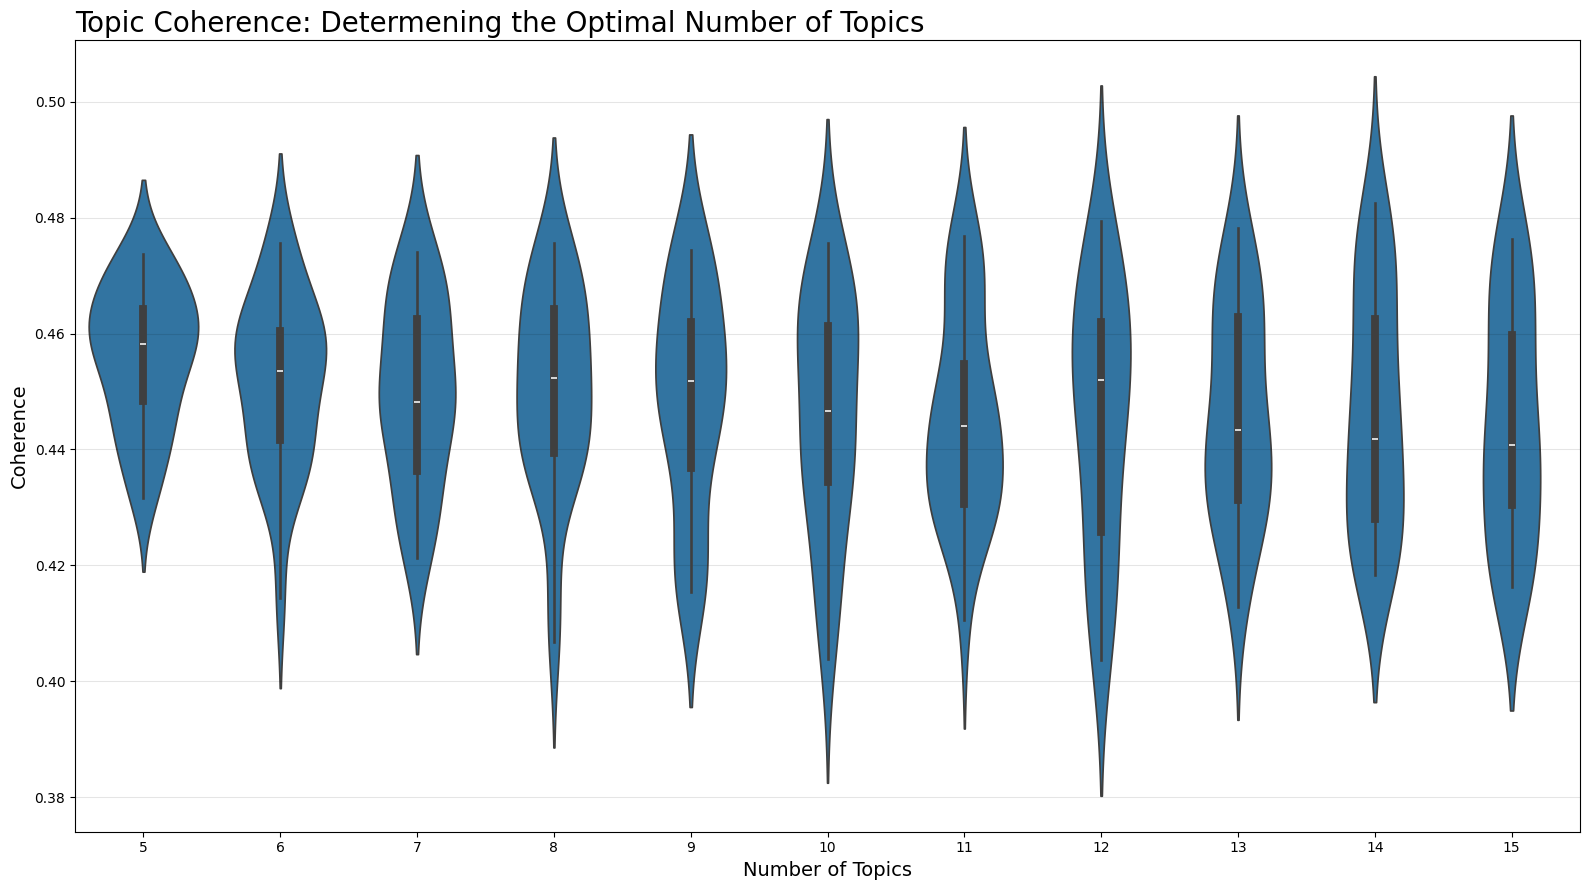

In [83]:
fig, ax = plt.subplots(figsize=(16,9))
sns.violinplot(ax=ax, data=results_df, x='num_topics', y='coherence')
ax.set_xlabel('Number of Topics', fontsize=14)
ax.set_ylabel('Coherence', fontsize=14)
ax.set_title('Topic Coherence: Determening the Optimal Number of Topics', loc='left', fontsize=20)
ax.yaxis.grid(color='black', which='both', alpha=0.1)
plt.tight_layout()
plt.show()

fig.savefig("../images/Topic Coherence.png", dpi=60)


In [12]:
lda_model = gensim.models.LdaMulticore(
                    corpus=corpus,
                    id2word=dictionary,
                    num_topics=14,
                    alpha=1.0,
                    eta=0.5
                )

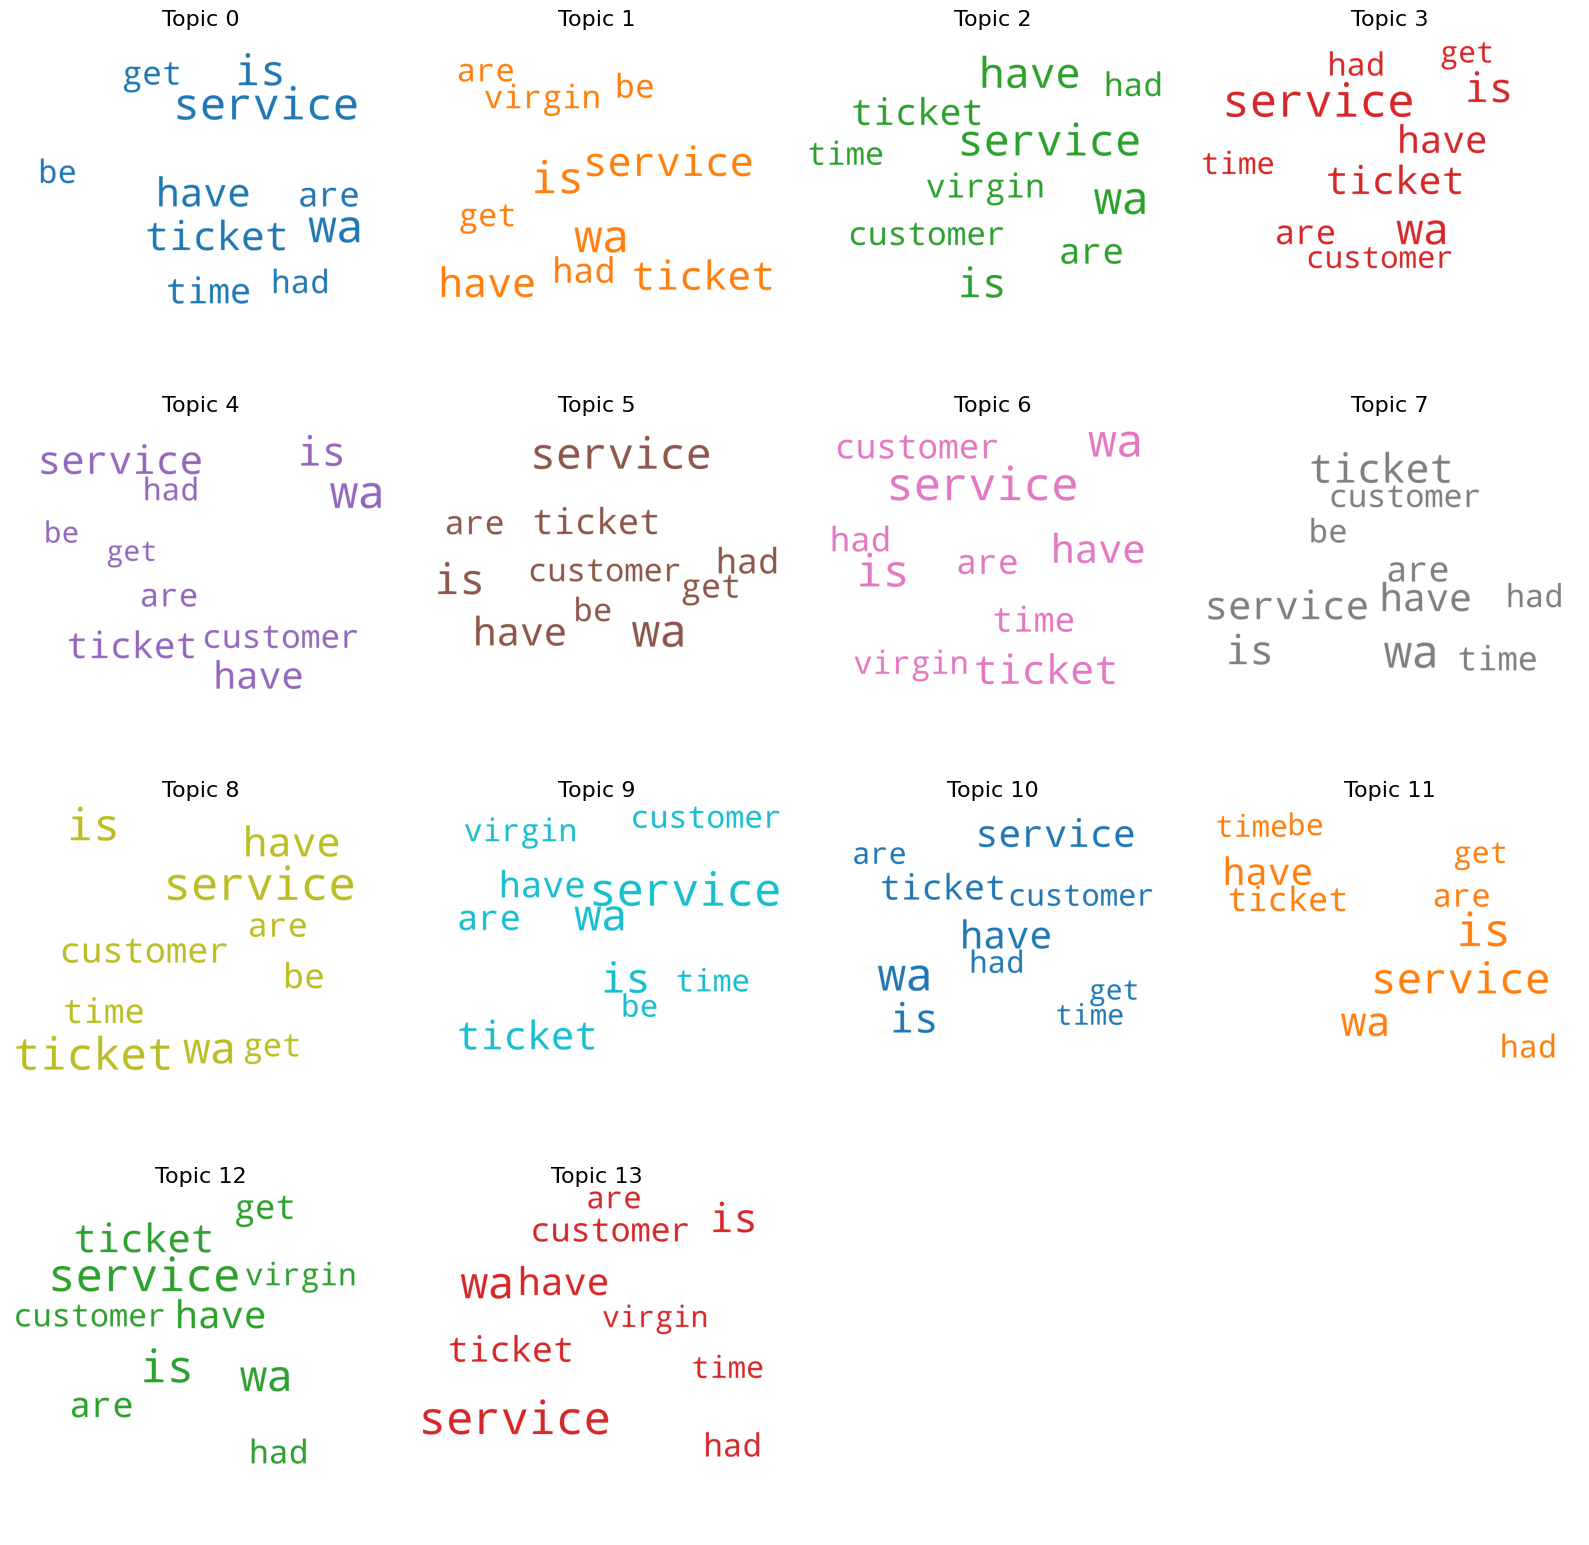

In [13]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # Color list for the word clouds

cloud = WordCloud(
    background_color='white',
    width=2500,
    height=1800,
    max_words=20,
    colormap='tab10',
    color_func=lambda *args, **kwargs: cols[i % len(cols)],  # Use modulo to cycle through colors
    prefer_horizontal=1.0)

topics = lda_model.show_topics(num_topics=14, formatted=False)  # Ensure 14 topics are retrieved

# Calculate the number of subplot rows and columns needed to accommodate 14 topics
n_rows = 4
n_cols = 4  # Using 4 columns, the last two subplots will be empty

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 16), sharex=True, sharey=True)

# Hide the last two axes as they won't display any topics
axes[-1, -2].axis('off')
axes[-1, -1].axis('off')

for i, ax in enumerate(axes.flatten()):  # Flatten the 2D array of axes for easy iteration
    if i < 14: 
        fig.add_subplot(ax)
        topic_words = dict(topics[i][1])
        cloud.generate_from_frequencies(topic_words, max_font_size=300)
        plt.gca().imshow(cloud)
        plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()
# Optionally save the figure
fig.savefig("../images/Optimized 14 Topics WordCloud.png", dpi=60)

## Sentence-BERT and word embeddings

Seeing as LDA has failed to identify any coherent topics, we will explore a method based on semantic word embeddings. We will try using Sentence-BERT to create embeddings of entire reviews, and clustering said reviews to identify the common topics of customer discontent.

<a id='sbert'></a>

In [14]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import euclidean_distances

In [115]:
def preprocess_text_sbert(
        text: str
    ) -> str:
    """Clean and preprocess the text."""
    text = re.sub(r'\s+', ' ', text)  
    text = text.strip().lower()
    return text

def generate_embeddings(
        reviews: List[str], 
        model_name: str = 'all-MiniLM-L6-v2'
    ) -> List[List[float]]:
    """Generate embeddings for a list of reviews using Sentence-BERT."""
    model = SentenceTransformer(model_name)
    embeddings = model.encode(reviews, show_progress_bar=True)
    return embeddings

def cluster_embeddings(
        embeddings: List[List[float]],
        n_clusters: int = 5
    ) -> Tuple[List[int], np.ndarray]:
    """Apply K-Means clustering to the embeddings and return the cluster labels and centroids."""
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(embeddings)
    centroids = kmeans.cluster_centers_
    return cluster_labels, centroids

def visualize_clusters(
        embeddings: List[List[float]], 
        cluster_labels: List[int],
        **kwargs: Any,
        ) -> None:
    
    subset = kwargs.get('subset', None)
    
    """Visualize the clusters using t-SNE and matplotlib, with a legend for clusters."""
    tsne = TSNE(n_components=2, perplexity=40, n_iter=300)
    tsne_results = tsne.fit_transform(embeddings)
    
    unique_labels = np.unique(cluster_labels)
    plt.figure(figsize=(10, 7))
    
    for label in unique_labels:
        # Filter data points belonging to the current cluster
        indices = [i for i, l in enumerate(cluster_labels) if l == label]
        cluster_tsne_results = tsne_results[indices]

        # Scatter plot for the cluster
        plt.scatter(cluster_tsne_results[:, 0], cluster_tsne_results[:, 1], label=f'Cluster {label + 1}', alpha=0.5)

    plt.colorbar(ticks=unique_labels)
    if subset is not None:
        plt.title(f'Cluster Visualization with t-SNE, Subset {subset}')
    else:
        plt.title('Cluster Visualization with t-SNE')
    plt.xlabel('t-SNE Feature 1')
    plt.ylabel('t-SNE Feature 2')
    plt.legend()
    plt.show()


def print_most_relevant_docs_per_cluster(
        data: List[dict], 
        embeddings: List[List[float]], 
        cluster_labels: List[int], 
        centroids: np.ndarray, 
        n_docs: int = 5
    ):
    """Print the most relevant documents for each cluster."""
    for cluster_id in range(centroids.shape[0]):
        # Find the indices of the documents in this cluster
        indices = [i for i, label in enumerate(cluster_labels) if label == cluster_id]

        # Calculate the distances of these documents to the cluster centroid
        cluster_embeddings = [embeddings[i] for i in indices]
        distances = euclidean_distances(cluster_embeddings, [centroids[cluster_id]])

        # Get the indices of the documents sorted by distance to the centroid
        sorted_indices = sorted(range(len(indices)), key=lambda i: distances[i])

        print(f"Cluster {cluster_id + 1}:")
        for i in range(n_docs):
            doc_index = indices[sorted_indices[i]]
            print(f"{data[doc_index]['title']} - {data[doc_index]['text']} {data[doc_index]['url']}")
        print("\n")

In [116]:
data = load_data(DATA_PATH)
reviews = [preprocess_text_sbert(review['title'] + " " + review['text'] + " " + review['url']) for review in data]
embeddings = generate_embeddings(reviews)

Removed 703 duplicates, 1318 reviews remain.


Batches:   0%|          | 0/42 [00:00<?, ?it/s]

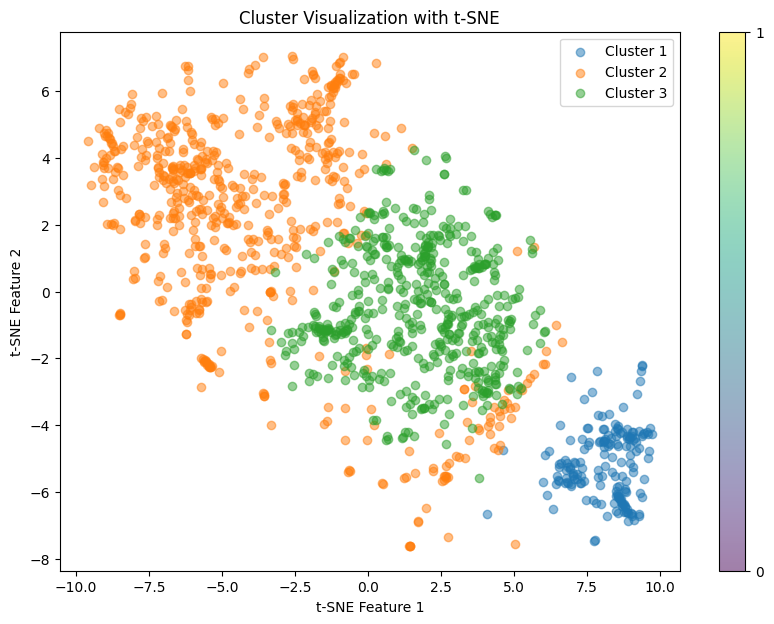

Cluster 1:
EUROSTAR fail! THEY WILL NEVER BE OUR FIRST CHOICE FOR TRAVEL - EUROSTAR fail! such a disappointment .. our train got cancelled, no customer service was provided at the time ABSOLUTE FAIL! ... we ended up driving last minute so we don’t loose out on our trip and activities and MIGHTY EUROSTAR is so poor they can’t even compensate the excess of less than £100 that we incurred above the cost of our ticket (not even mentioning stress incurred and travelling whole night for a weekend break booked in advance which was 2k... we chose alternative route because we didn’t want to miss out as no one would give us a refund and we didn’t have any other choice because no one from EUROSTAR bothered to show up or advice other than go in their website - which was crashing all the time - AS EXPECTED and tickets available for next day at reasonable time were all gone!) ... well done EUROSTAR! ... i would think twice before choosing your service again! www.eurostar.com
Terrible customer servic

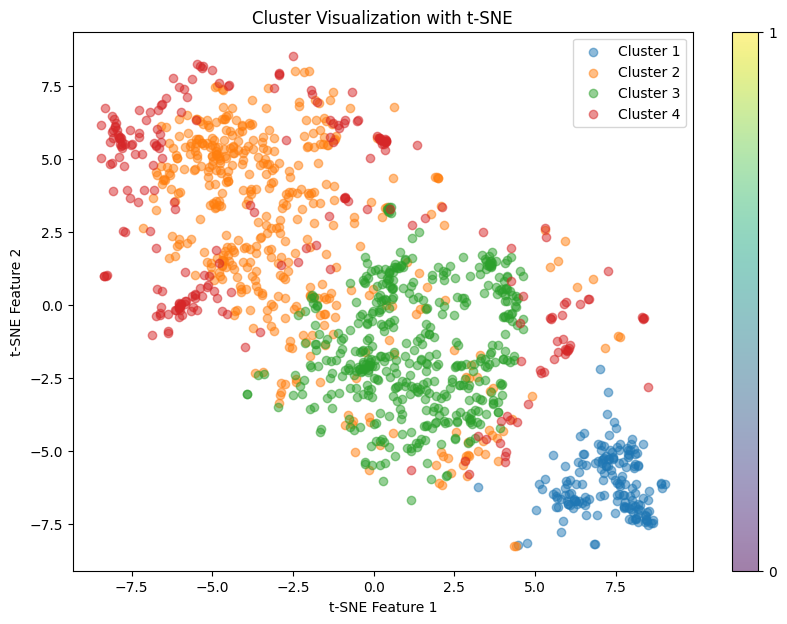

Cluster 1:
EUROSTAR fail! THEY WILL NEVER BE OUR FIRST CHOICE FOR TRAVEL - EUROSTAR fail! such a disappointment .. our train got cancelled, no customer service was provided at the time ABSOLUTE FAIL! ... we ended up driving last minute so we don’t loose out on our trip and activities and MIGHTY EUROSTAR is so poor they can’t even compensate the excess of less than £100 that we incurred above the cost of our ticket (not even mentioning stress incurred and travelling whole night for a weekend break booked in advance which was 2k... we chose alternative route because we didn’t want to miss out as no one would give us a refund and we didn’t have any other choice because no one from EUROSTAR bothered to show up or advice other than go in their website - which was crashing all the time - AS EXPECTED and tickets available for next day at reasonable time were all gone!) ... well done EUROSTAR! ... i would think twice before choosing your service again! www.eurostar.com
Terrible customer servic

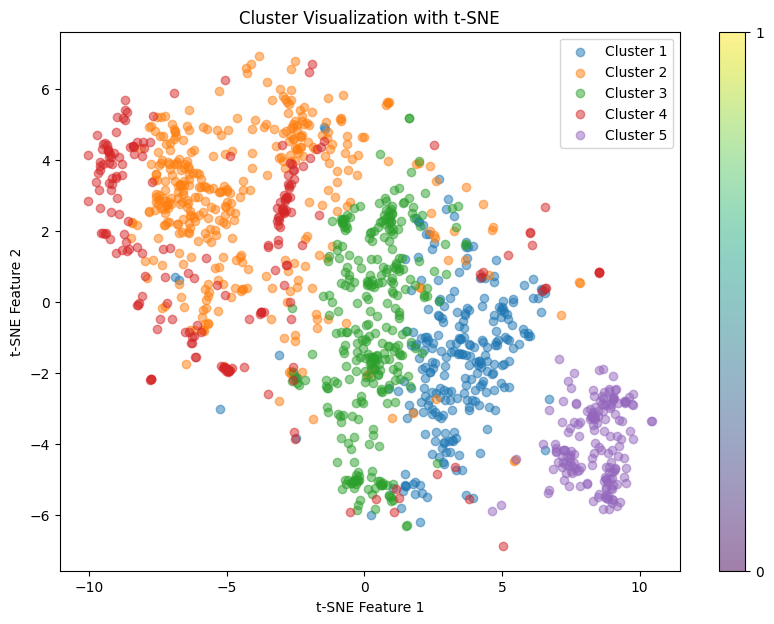

Cluster 1:
Still terrible - So bad customer service. The waiting time to get response is unbelievable .  I'm waiting about 8 months for refund my ticket .    Also I'm in train already which is 85 minute delay !!   The delay repay  scheme it is not fair ! www.virgintrains.co.uk
Do not use virgin trains! - I booked a virgin train ticket online but had to use the London Midland website because the virgin website kept crashing at the payment screen. When I got to Euston to collect my ticket from the machines there was a software problem so I could not retrieve my tickets so I showed a virgin customer service assistant my receipt and explained my circumstances but he refused to let me travel insisting I had to buy another ticket at a cost of £33. He was extremely rude and condescending and I had to go home and come back the next day and pay to travel again at gross inconvenience. I contacted virgin and they took a month to reply only to offer me a half price ticket for my next journey takin

In [117]:
for num_topics in [3,4,5]:
    cluster_labels, centroids = cluster_embeddings(embeddings, n_clusters=num_topics)
    visualize_clusters(embeddings, cluster_labels)
    print_most_relevant_docs_per_cluster(data, embeddings, cluster_labels, centroids, n_docs=3)

## Clustering by train company

Sentence-BERT was a lot more insightful. We now know that users are mainly dissatisfied with the customer service, unexpected delays and cancellations, and high prices for poor quality service. Now we can explore what customers are saying about each of the companies independently. 

After analyzing the URLs from which the reviews have been taken, we have identified 5 subsets: Virgin Trains, Southern Railway, GWR, and Eurostar. The fifth subset contains reviews from the remaining train companies that have fewer than 100 reviews.

In [118]:
url_counts = Counter(review['url'] for review in data if 'url' in review)

# Sort the counts in descending order
sorted_url_counts = sorted(url_counts.items(), key=lambda x: x[1], reverse=True)

# Print the sorted counts
for url, count in sorted_url_counts:
    print(f"{url}: {count}")

www.virgintrains.co.uk: 410
www.southernrailway.com: 251
www.gwr.com: 173
www.eurostar.com: 172
www.virgintrainseastcoast.com: 108
www.nationalrail.co.uk: 60
www.buytickets.crosscountrytrains.co.uk: 20
www.eastmidlandstrains.co.uk: 19
www.tpexpress.co.uk: 18
www.southeasternrailway.co.uk: 18
www.arrivatrainswales.co.uk: 17
www.grandcentralrail.com: 17
www.southwesternrailway.com: 13
chilternrailways.co.uk: 8
www.londonnorthwesternrailway.co.uk: 8
sleeper.scot: 5
www.hulltrains.co.uk: 1


In [119]:
def split_data_by_url(data: List[Dict]) -> Dict[str, List[Dict]]:
    """Split data into subsets based on the URL."""
    subsets = {
        '1': [],
        '2': [],
        '3': [],
        '4': [],
        '5': []
    }
    
    for entry in data:
        url = entry['url']
        if url in ['www.virgintrains.co.uk', 'www.virgintrainseastcoast.com']:
            subsets['1'].append(entry)
        elif url in ['www.southernrailway.com', 'www.southeasternrailway.co.uk', 'www.southwesternrailway.com']:
            subsets['2'].append(entry)
        elif url == 'www.gwr.com':
            subsets['3'].append(entry)
        elif url == 'www.eurostar.com':
            subsets['4'].append(entry)
        else:
            subsets['5'].append(entry)
    return subsets



In [120]:
data = load_data(DATA_PATH)
subsets = split_data_by_url(data)

Removed 703 duplicates, 1318 reviews remain.


In [121]:
for idx, subset in subsets.items():
    print(subset[100]['url'])

www.virgintrains.co.uk
www.southernrailway.com
www.gwr.com
www.eurostar.com
www.arrivatrainswales.co.uk


1


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

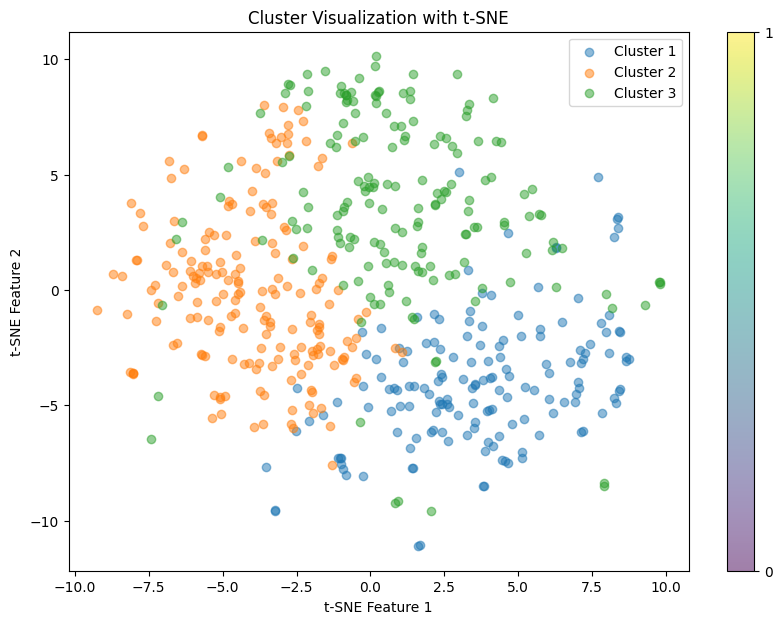

Cluster 1:
What a terrible customer service - What a terrible customer service. Not a one single reply to two messages I sent over two weeks. I am trying to get my refund but no one is answering me despite I already applied for a refund two weeks ago. I now have two tickets for the same journey. Never again, will stick to Trainline as I used to before. I will not book a ticket from Virgin ever again. Worse customer service ever!!!!!! www.virgintrains.co.uk
Still terrible - So bad customer service. The waiting time to get response is unbelievable .  I'm waiting about 8 months for refund my ticket .    Also I'm in train already which is 85 minute delay !!   The delay repay  scheme it is not fair ! www.virgintrains.co.uk
Absolutely awful customer service - Absolutely awful customer service, I have been trying to get a refund for a ticket but they are the most unhelpful company ever. You cannot speak to them over the phone only via a compliant form that they do not reply too! I have been r

Batches:   0%|          | 0/9 [00:00<?, ?it/s]

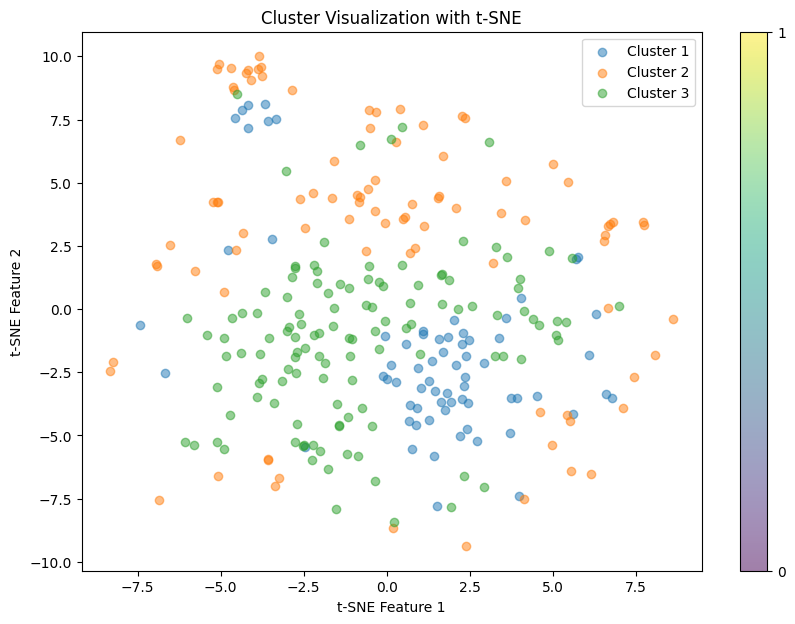

Cluster 1:
Terrible - I've been using Southern to commute to and from London for years it's far and away the worst service I have ever used and I'm shocked that's it's become even worse. Trains constantly late and the new excuse crew shortages and Conductor sickness is just a joke.  Southern should lose their franchise worst rail company in the UK. www.southernrailway.com
Southern Rail: So Glad I Moved Away - I commuted from Redhill for 28 years, and saw a service which just got worse every year.  The old slam door trains of British Rail days may have had their faults but generally they got to London Bridge faster than first franchise holder Notwork SouthCentral,  and very much quicker than the totally rubbish service offered by Southern.  Southern are just one big rip off company who con politicians and the travelling public with excessive fares and poor service, while their totally useless self-important managers stuff their pockets with commuters hard-earned cash and care nothing fo

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

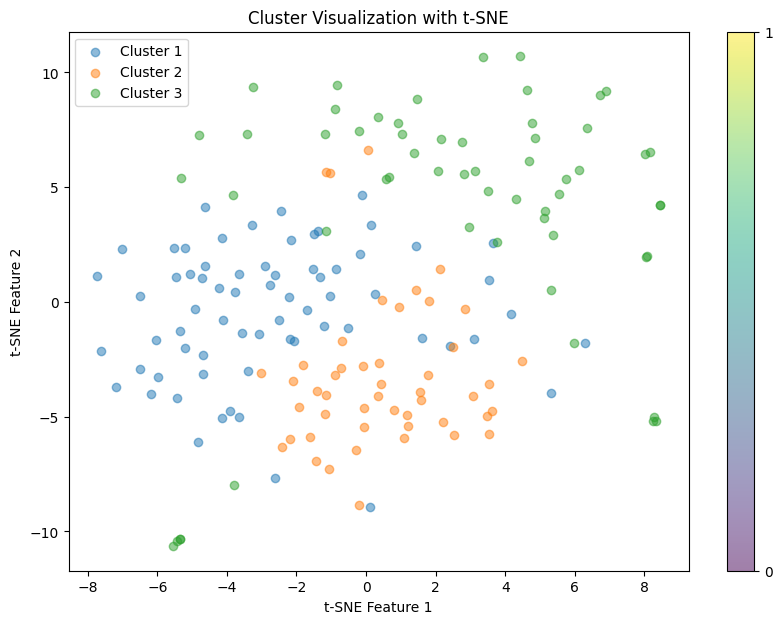

Cluster 1:
Took me three and a half hours to get … - Took me three and a half hours to get home today, after every single possible train I had to get was cancelled. Thanks GWR possibly the single worst railway company in existence, have had exactly the same issue with them before. Overpriced and absolute garbage. Would highly suggest you use another service. www.gwr.com
This is the worst train line ever to … - This is the worst train line ever to exist! The customer service is shameful and disgraceful. Currently on a 2pm train to penzance from London. £80 ticket and having to stand squished in corridor as the train is over crowded. Secondly an unscheduled stop was made in reading to pick up more passengers. Meaning the train is delayed and also even more crowded. Absolutely disgusting. You are a horrific train line that is a money making disgace .  I whoever runs this shambles of a company goes bankrupt www.gwr.com
Truly terrible service in all respects - 6 out of 8 of my last journeys

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

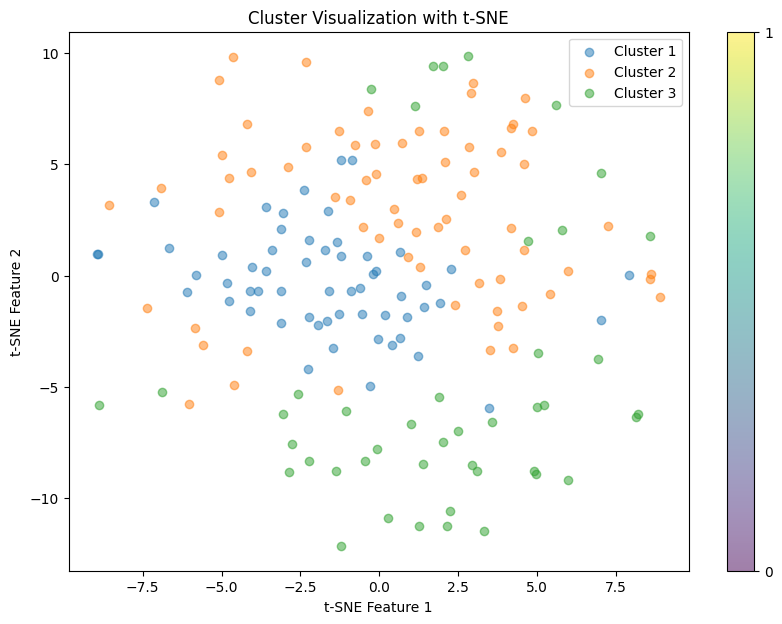

Cluster 1:
EUROSTAR fail! THEY WILL NEVER BE OUR FIRST CHOICE FOR TRAVEL - EUROSTAR fail! such a disappointment .. our train got cancelled, no customer service was provided at the time ABSOLUTE FAIL! ... we ended up driving last minute so we don’t loose out on our trip and activities and MIGHTY EUROSTAR is so poor they can’t even compensate the excess of less than £100 that we incurred above the cost of our ticket (not even mentioning stress incurred and travelling whole night for a weekend break booked in advance which was 2k... we chose alternative route because we didn’t want to miss out as no one would give us a refund and we didn’t have any other choice because no one from EUROSTAR bothered to show up or advice other than go in their website - which was crashing all the time - AS EXPECTED and tickets available for next day at reasonable time were all gone!) ... well done EUROSTAR! ... i would think twice before choosing your service again! www.eurostar.com
Awful customer service -

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

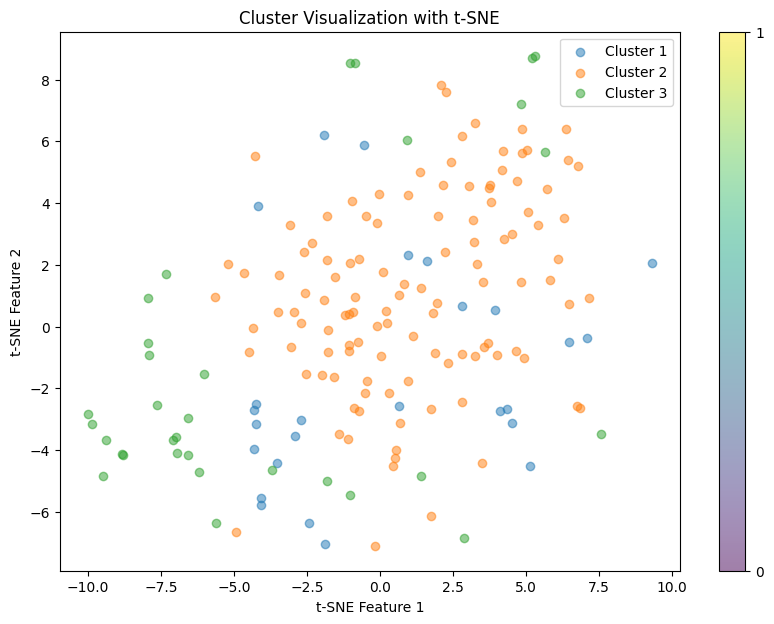

Cluster 1:
Truly dreadful trains at vastly inflated prices - Took the 18.15 from Reading to Macclesfield once a week every week last year. Nearly 3 hours to travel 170 miles.  Only once tried standard class - utterly vile.  Scrum to get on.  Old small seats so packed up against other people with nowhere to put a suitcase.   Had to upgrade (at my own not employer expense) to first class just to get a seat.  Too few carriages resulting in appalling inhumane overcrowding.  People pressed against the glass like flies, and sitting/standing in every available inch of toilets, carriages and corridors.  Surprisingly little abuse from  passengers - in France there'd be riots if people were treated this badly.  Grotty trolley clatters eventually through in first class and had to pay for 'dinner' in the form of the measly overpriced cheese & pickle sandwich, crisps and warm wine or warm beer.  (Eventually cracked and now travel from Slough to Paddington across London to get to Euston for a 'prope

In [122]:
for idx, subset in subsets.items():
    print(idx)
    reviews = [preprocess_text_sbert(review['title'] + " " + review['text']) for review in subset]
    embeddings = generate_embeddings(reviews)
    for num_topics in [3]:
        cluster_labels, centroids = cluster_embeddings(embeddings, n_clusters=num_topics)
        visualize_clusters(embeddings, cluster_labels)
        print_most_relevant_docs_per_cluster(subset, embeddings, cluster_labels, centroids, n_docs=3)
        